Load MNIST data

In [1]:
import torch.utils.data
from torchvision import transforms, datasets

use_cuda = torch.cuda.is_available()

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, pin_memory=use_cuda,
                                          num_workers=3)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                        shuffle=False, pin_memory=use_cuda,
                                        num_workers=3)

batch_shape = next(iter(trainloader))[0].shape
in_dim = batch_shape[-1]*batch_shape[-2]

Define Bayesian Neural Network

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam, PyroSample
from torch.distributions import constraints
import torch.nn.functional as F

class BayesianLinear(PyroModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.bias = PyroSample(prior=dist.LogNormal(0, 1).expand([out_size]).to_event(1))
        self.weight = PyroSample(prior=dist.Normal(0, 1).expand([in_size, out_size]).to_event(2))

    def forward(self, input):
        return self.bias + input @ self.weight  # this line samples bias and weight
    
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, in_size, h1, out_size):
        super().__init__()
        self.fc1 = BayesianLinear(in_size, h1) 
        self.fc2 = BayesianLinear(h1, out_size) 

    def forward(self, input, output=None):
        x = self.fc1(input)
        x = F.relu(x)
        x = self.fc2(x)
        with pyro.plate("instances", len(input)):
            return pyro.sample("obs", dist.Categorical(logits=x), obs=output)

Train the network

In [3]:
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal

import pdb 

pyro.clear_param_store()

h1 = 1024
bnn = BayesianNeuralNetwork(in_dim, h1, 10)
guide = AutoNormal(bnn)
svi = SVI(model=bnn,
          guide=guide,
          optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
          loss=Trace_ELBO())

epochs = 10
losses = []
for epoch in range(epochs):
    print('Epoch {}:'.format(epoch))
    for data, labels in trainloader:
        data = data.view(data.shape[0],-1)
        out = bnn(data)
        losses.append(svi.step(data, labels))
    print('Mean fc1 weight value: {:.4f}'.format(\
             torch.mean(guide.locs.fc1.state_dict()['weight_unconstrained'])))
    print('Mean fc2 weight value: {:.4f}'.format(\
             torch.mean(guide.locs.fc2.state_dict()['weight_unconstrained'])))
    print('Train loss: {:.4f}'.format(losses[-1]))

Epoch 0:
Mean fc1 weight value: 0.0005
Mean fc2 weight value: -0.0000
Train loss: 1063211.3478
Epoch 1:
Mean fc1 weight value: 0.0011
Mean fc2 weight value: -0.0000
Train loss: 679205.0145
Epoch 2:
Mean fc1 weight value: 0.0018
Mean fc2 weight value: 0.0000
Train loss: 356559.3447
Epoch 3:
Mean fc1 weight value: 0.0027
Mean fc2 weight value: -0.0000
Train loss: 140025.0437
Epoch 4:


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

Mean fc1 weight value: nan
Mean fc2 weight value: nan
Train loss: nan
Epoch 5:


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

Mean fc1 weight value: nan
Mean fc2 weight value: nan
Train loss: nan
Epoch 6:


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

Mean fc1 weight value: nan
Mean fc2 weight value: nan
Train loss: nan
Epoch 7:


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

Mean fc1 weight value: nan
Mean fc2 weight value: nan
Train loss: nan
Epoch 8:


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

Mean fc1 weight value: nan
Mean fc2 weight value: nan
Train loss: nan
Epoch 9:


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.

Mean fc1 weight value: nan
Mean fc2 weight value: nan
Train loss: nan


/home/rothor/miniconda3/envs/ml/lib/python3.8/site-packages/pyro/infer/trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


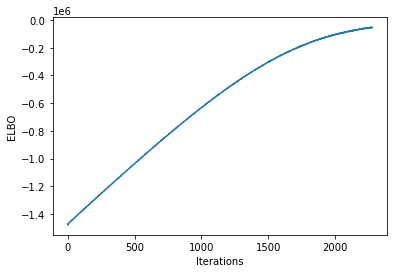

In [5]:
import matplotlib.pyplot as plt 

plt.plot(-torch.tensor(losses))
plt.xlabel('Iterations')
plt.ylabel('ELBO')
plt.show()